<a href="https://colab.research.google.com/github/ManuelProy/digital-invoice/blob/main/digital-invoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice OCR notebook series: Problem definition

> Given a arbitrary photo containing a receipt, extract grand total number

![](https://storage.googleapis.com/www.forwardit.lv/kaggle/receipt_home_kaggle.png)

The solution is divided into smaller tasks:

1. Get a scanned version of receipt by restoring perspective (done in the [previous notebook](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv))
2. **Apply OCR to find all texts within image**
3. **Find grand total as the largest number among recognized texts**

> One should remember that some tasks could be solved with traditional computer vision algorithms

This work aims to address a common pitfall among machine learning practitioners: trying to solve simple problems with the complex tools.

# About this notebook

This is a **part two notebook** in the *Receipt OCR with OpenCV* series. [Previously](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv) we have extracted a scanned version of the receipt out of the image. This notebook deals with the second step of the process: reading text information from it.
* Locating text boxes on the image
* Extracting all the texts from the image
* Obtaining grand total as the largest floating point number among texts

Let's get started!

In [2]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! sudo apt-get install tesseract-ocr-spa
! pip install Pillow
! pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,154 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re
from PIL import Image
import os
from pytesseract import Output
import string

Defining helper methods:

In [4]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [5]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
def deskew(image):

  co_ords = np.column_stack(np.where(image > 0))

  angle = cv2.minAreaRect(co_ords)[-1]

  if angle < -45:

    angle = -(90 + angle)

  else:

    angle = -angle

    (h, w) = image.shape[:2]

    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC,

    borderMode=cv2.BORDER_REPLICATE)

  return rotated

We will use a scanned version of the receipt, which is the output of the [previous notebook in the series](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv):

In [7]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


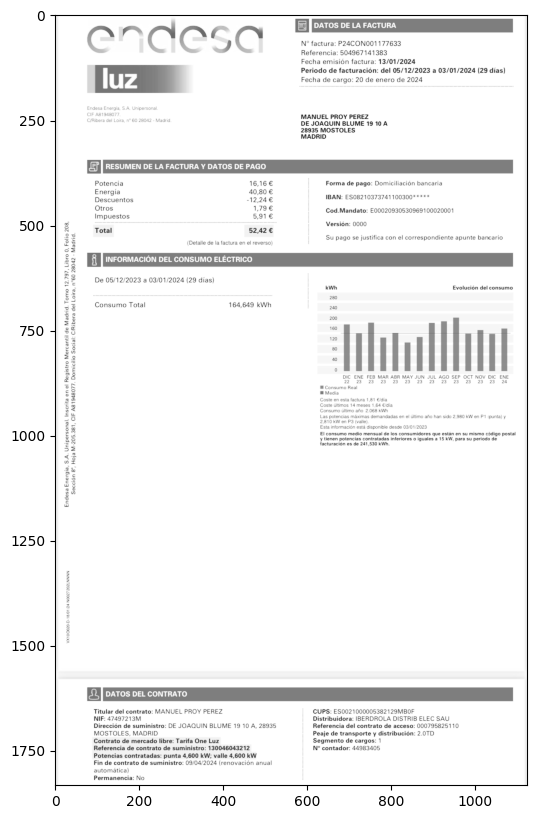

In [8]:
file_name = '/content/drive/MyDrive/dig-invoice/fact3.jpeg'
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)

# Step 1: Text box detection

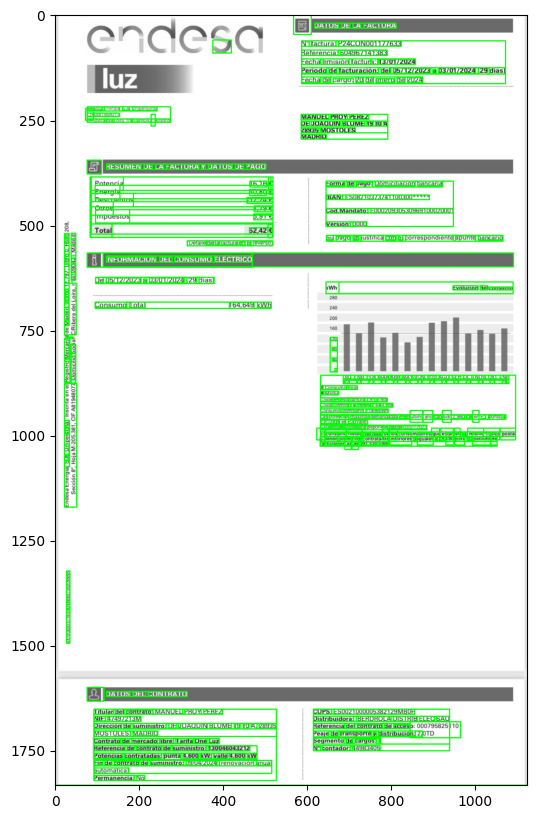

In [9]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)

Step 1b: Find the rentagle with higher area

> Bloque con sangría



In [10]:
# Get bounding box estimates
print(pytesseract.image_to_boxes(Image.open('/content/drive/MyDrive/dig-invoice/fact3.jpeg')))

# Get verbose data including boxes, confidences, line and page numbers
#print(pytesseract.image_to_data(Image.open('/content/drive/MyDrive/dig-invoice/fact3.jpeg')))

C 385 1773 394 1818 0
c 385 1777 397 1807 0
B 571 1791 605 1824 0
D 617 1802 627 1814 0
A 617 1802 627 1814 0
T 629 1802 639 1814 0
O 641 1803 650 1814 0
S 652 1802 673 1814 0
D 681 1802 689 1814 0
E 681 1802 701 1814 0
L 708 1802 719 1814 0
A 708 1802 727 1814 0
F 734 1803 741 1814 0
A 743 1802 753 1814 0
C 755 1802 764 1814 0
T 766 1803 774 1814 0
U 777 1802 787 1814 0
R 790 1802 798 1814 0
A 800 1803 810 1814 0
= 108 1771 141 1780 0
f 152 1772 163 1805 0
= 328 1772 361 1780 0
i 406 1747 419 1783 0
I 485 1744 494 1776 0
N 586 1759 595 1772 0
° 586 1759 605 1772 0
f 609 1759 614 1772 0
a 609 1759 623 1772 0
c 618 1759 634 1772 0
t 624 1759 637 1770 0
u 639 1759 647 1768 0
r 649 1759 655 1768 0
a 655 1759 663 1768 0
: 665 1759 668 1768 0
P 674 1759 683 1772 0
2 684 1759 692 1772 0
4 690 1759 707 1772 0
C 693 1759 713 1772 0
O 714 1759 726 1772 0
N 727 1759 739 1772 0
0 740 1759 748 1772 0
0 742 1759 758 1772 0
1 749 1759 758 1772 0
1 759 1759 774 1771 0
7 768 1759 789 1772 0
7 777 1759

# Step 2: Text recognition

In [11]:
extracted_text = pytesseract.image_to_string(image,lang="spa")
print(extracted_text)
type(extracted_text)


E
3
3
8

2
3
2
3
2
É
5
E
E
3
>

  

 

Registro Mercanti

. Domicilio Soci

3
2
3
<
a

 

VK100020.0-18:01/24 N0027202LNNNN

 

J)

Endesa Energía, S.A. Unipersonal
CIF AB1948077.
C/Ribera del Loi, n” 60 28042 - Madri.

 

Potencia 16,16€
Energía 40,80 €
Descuentos -12,24 €
Otros 179€
Impuestos 5,91 €
Total 52,42 €

(Detalle de la factura en el reverso)

INFORMACIÓN DEL CONSUMO ELÉCTRICO

 

ANA AT

N? factura: P24C0N001177633

Referencia: 504967141383

Fecha emisión factura: 13/01/2024

Periodo de facturación: del 05/12/2023 a 03/01/2024 (29 días)
Fecha de cargo: 20 de enero de 2024

 

MANUEL PROY PEREZ

DE JOAQUIN BLUME 19 10 A
28935 MOSTOLES

MADRID

EUA INIA

Forma de pago: Domiciliación bancaria
IBAN: ESO8210373741100300*****
Cod.Mandato: E00020930530969100020001
Versión: 0000

Su pago se justifica con el correspondiente apunte bancario

 

De 05/12/2023 a 03/01/2024 (29 días)

Consumo Total 164,649 kWh

AN LO)

Titular del contrato: MANUEL PROY PEREZ

NIF: 47497213M

Dirección d

str

In [12]:
text = os.linesep.join([s for s in extracted_text.splitlines() if s])
print(text)

E
3
3
8
2
3
2
3
2
É
5
E
E
3
>
  
 
Registro Mercanti
. Domicilio Soci
3
2
3
<
a
 
VK100020.0-18:01/24 N0027202LNNNN
 
J)
Endesa Energía, S.A. Unipersonal
CIF AB1948077.
C/Ribera del Loi, n” 60 28042 - Madri.
 
Potencia 16,16€
Energía 40,80 €
Descuentos -12,24 €
Otros 179€
Impuestos 5,91 €
Total 52,42 €
(Detalle de la factura en el reverso)
INFORMACIÓN DEL CONSUMO ELÉCTRICO
 
ANA AT
N? factura: P24C0N001177633
Referencia: 504967141383
Fecha emisión factura: 13/01/2024
Periodo de facturación: del 05/12/2023 a 03/01/2024 (29 días)
Fecha de cargo: 20 de enero de 2024
 
MANUEL PROY PEREZ
DE JOAQUIN BLUME 19 10 A
28935 MOSTOLES
MADRID
EUA INIA
Forma de pago: Domiciliación bancaria
IBAN: ESO8210373741100300*****
Cod.Mandato: E00020930530969100020001
Versión: 0000
Su pago se justifica con el correspondiente apunte bancario
 
De 05/12/2023 a 03/01/2024 (29 días)
Consumo Total 164,649 kWh
AN LO)
Titular del contrato: MANUEL PROY PEREZ
NIF: 47497213M
Dirección de suministro: DE JOAQUIN BLUME 19 1

In [13]:
di=[]
for line in extracted_text.splitlines():
    if len(line)>=4:
      print(line+' len: '+str(len(line)))
      di.append(line)


Registro Mercanti len: 17
. Domicilio Soci len: 16
VK100020.0-18:01/24 N0027202LNNNN len: 33
Endesa Energía, S.A. Unipersonal len: 32
CIF AB1948077. len: 14
C/Ribera del Loi, n” 60 28042 - Madri. len: 38
Potencia 16,16€ len: 15
Energía 40,80 € len: 15
Descuentos -12,24 € len: 19
Otros 179€ len: 10
Impuestos 5,91 € len: 16
Total 52,42 € len: 13
(Detalle de la factura en el reverso) len: 37
INFORMACIÓN DEL CONSUMO ELÉCTRICO len: 33
ANA AT len: 6
N? factura: P24C0N001177633 len: 27
Referencia: 504967141383 len: 24
Fecha emisión factura: 13/01/2024 len: 33
Periodo de facturación: del 05/12/2023 a 03/01/2024 (29 días) len: 61
Fecha de cargo: 20 de enero de 2024 len: 35
MANUEL PROY PEREZ len: 17
DE JOAQUIN BLUME 19 10 A len: 24
28935 MOSTOLES len: 14
MADRID len: 6
EUA INIA len: 8
Forma de pago: Domiciliación bancaria len: 37
IBAN: ESO8210373741100300***** len: 30
Cod.Mandato: E00020930530969100020001 len: 37
Versión: 0000 len: 13
Su pago se justifica con el correspondiente apunte bancario le

[texto del enlace](https://)# Step 3: Extracting invoice lines

We will use regular expression to extract all floating point numbers out of the all detected texts.

In [14]:
di

['Registro Mercanti',
 '. Domicilio Soci',
 'VK100020.0-18:01/24 N0027202LNNNN',
 'Endesa Energía, S.A. Unipersonal',
 'CIF AB1948077.',
 'C/Ribera del Loi, n” 60 28042 - Madri.',
 'Potencia 16,16€',
 'Energía 40,80 €',
 'Descuentos -12,24 €',
 'Otros 179€',
 'Impuestos 5,91 €',
 'Total 52,42 €',
 '(Detalle de la factura en el reverso)',
 'INFORMACIÓN DEL CONSUMO ELÉCTRICO',
 'ANA AT',
 'N? factura: P24C0N001177633',
 'Referencia: 504967141383',
 'Fecha emisión factura: 13/01/2024',
 'Periodo de facturación: del 05/12/2023 a 03/01/2024 (29 días)',
 'Fecha de cargo: 20 de enero de 2024',
 'MANUEL PROY PEREZ',
 'DE JOAQUIN BLUME 19 10 A',
 '28935 MOSTOLES',
 'MADRID',
 'EUA INIA',
 'Forma de pago: Domiciliación bancaria',
 'IBAN: ESO8210373741100300*****',
 'Cod.Mandato: E00020930530969100020001',
 'Versión: 0000',
 'Su pago se justifica con el correspondiente apunte bancario',
 'De 05/12/2023 a 03/01/2024 (29 días)',
 'Consumo Total 164,649 kWh',
 'AN LO)',
 'Titular del contrato: MANUE

In [15]:
patron = r'\b\d+,\d+\b'
resultados = re.findall(patron, extracted_text)

print(resultados)

['16,16', '40,80', '12,24', '5,91', '52,42', '164,649', '4,600', '4,600', '1,81', '1,64', '241,530']


Grand total is the largest one:

In [16]:
def lines(extracted_text):
    lineas_con_numeros = [linea for linea in extracted_text.splitlines() if re.search(r'^(?=.*[a-zA-Z])(?=.*\d.*,\d).*$', linea)]
    diccionario = {f"Línea {i + 1}": linea for i, linea in enumerate(lineas_con_numeros)}

    return(diccionario)

In [17]:
lines(extracted_text)



{'Línea 1': 'Potencia 16,16€',
 'Línea 2': 'Energía 40,80 €',
 'Línea 3': 'Descuentos -12,24 €',
 'Línea 4': 'Impuestos 5,91 €',
 'Línea 5': 'Total 52,42 €',
 'Línea 6': 'Consumo Total 164,649 kWh',
 'Línea 7': 'Potencias contratadas: punta 4,600 kW; valle 4,600 kW',
 'Línea 8': 'Coste en esta factura 1,81 día',
 'Línea 9': 'Coste úlimos 14 meses 1,64 Eldía',
 'Línea 10': 'facturación es de 241,530 kWh.'}


# Step 4: Extracting lines with important dates

We will use regular expression to extract all lines with dates

In [19]:
def find_dates(text, pattern):
    return re.findall(pattern, text)
text = "The date is 09/02/2023 and the other date is 12-12-2024."
pattern = r"\b(0[1-9]|1[0-2])[-/](0[1-9]|[12]\d|3[01])[-/](19\d\d|20\d\d)\b"
dates = find_dates(extracted_text, pattern)
print("Dates found:", dates)

Dates found: [('05', '12', '2023'), ('03', '01', '2024'), ('05', '12', '2023'), ('03', '01', '2024'), ('09', '04', '2024'), ('03', '01', '2023')]


In [23]:
pattern = r"\b(0[1-9]|1[0-2])[-/](0[1-9]|[12]\d|3[01])[-/](19\d\d|20\d\d)\b"

date_lines = [linea for linea in extracted_text.splitlines() if re.findall(pattern, linea)]

print(date_lines)

['Periodo de facturación: del 05/12/2023 a 03/01/2024 (29 días)', 'De 05/12/2023 a 03/01/2024 (29 días)', 'Fin de contrato de suministro: 09/04/2024 (renovación anual', 'Esta información está disponible desde 03/01/2023']


Feel free to experiment with other regular expressions to find VAT number, company name, date or even read receipt positions!

# Resources

1. https://livefiredev.com/how-to-extract-table-from-image-in-python-opencv-ocr/